# Gallery for DR8

The purpose of this notebook is to build a nice gallery of object images for DR8.  The theme is intermediate-redshift galaxy clusters.

For future reference: The notebook must be run from https://jupyter.nersc.gov with the following (approximate) activation script:

```bash
#!/bin/bash                                                                                                           
version=$1                                                                                                            
connection_file=$2                                                                                                    

desiconda_version=20180512-1.2.5-img
module use /global/common/software/desi/$NERSC_HOST/desiconda/$desiconda_version/modulefiles
module load desiconda

export LEGACYPIPE_DIR=$HOME/repos/git/legacypipe                                                                       

export PATH=$LEGACYPIPE_DIR/bin:${PATH}                                                                               
export PYTHONPATH=$LEGACYPIPE_DIR/py:${PYTHONPATH}                                                                    

export DUST_DIR=/global/project/projectdirs/desi/software/${NERSC_HOST}/dust/v0_0

export UNWISE_COADDS_DIR=/global/projecta/projectdirs/cosmo/work/wise/outputs/merge/neo4/fulldepth:/global/project/projectdirs/cosmo/data/unwise/allwise/unwise-coadds/fulldepth
export UNWISE_COADDS_TIMERESOLVED_DIR=/global/projecta/projectdirs/cosmo/work/wise/outputs/merge/neo4

export GAIA_CAT_DIR=/global/project/projectdirs/cosmo/work/gaia/chunks-gaia-dr2-astrom/
export GAIA_CAT_VER=2

export TYCHO2_KD_DIR=/global/project/projectdirs/cosmo/staging/tycho2

export PS1CAT_DIR=/global/project/projectdirs/cosmo/work/ps1/cats/chunks-qz-star-v3 # calibration only

exec python -m ipykernel -f $connection_file
```

### Imports and paths

In [1]:
import os, sys
import shutil, time, warnings
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [2]:
import fitsio
from astropy.io import ascii
import astropy.units as u
from astropy.coordinates import SkyCoord, FK5
from astropy.table import Table, vstack, Column
from astropy.cosmology import FlatLambdaCDM
from PIL import Image, ImageDraw, ImageFont

In [3]:
from legacypipe.survey import LegacySurveyData
from legacypipe.runbrick import run_brick
from astrometry.util.util import Tan
from astrometry.util.fits import merge_tables
from astrometry.libkd.spherematch import match_radec

In [4]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [5]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) 

In [6]:
%matplotlib inline

### Preliminaries

Define the data release and the various output directories.

In [7]:
PIXSCALE = 0.262
#PIXSCALE = 2.62

In [8]:
dr = 'dr8'
drdir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8'
gallerydir = os.path.join( os.getenv('SCRATCH'), dr, 'gallery')
samplefile = os.path.join(gallerydir, 'sample-{}.fits'.format(dr))

In [9]:
jpgdir = os.path.join(gallerydir, 'jpg')
if not os.path.isdir(jpgdir):
    os.mkdir(jpgdir)

In [10]:
pngdir = os.path.join(gallerydir, 'png')
if not os.path.isdir(pngdir):
    os.mkdir(pngdir)

### Build the sample.

Use the sample of clusters from http://risa.stanford.edu/redmapper/redmapper_dr8_public_v6.3_catalog.fits.gz

Cut to lambda>100, corresponding to M(halo) = (0.1-3) x 10^15 Msun over the redshift range 0.1-0.5.

In [11]:
def read_redmapper(radius_kpc=200, seed=1, npilot=100, 
                   richmin=20, richmax=300, zmin=0.1, 
                   zmax=0.5):
    rmfile = os.path.join(gallerydir, 'redmapper_dr8_public_v6.3_catalog.fits.gz')
    cat = Table(fitsio.read(rmfile, lower=True))
    cut = ((cat['lambda'] > richmin) * (cat['z_lambda'] > zmin) * 
           (cat['z_lambda'] < zmax) * (cat['p_cen'][:, 0] > 0.9))
    cat = cat[cut]
    
    # Choose 100 clusters drawn uniformly in richness
    #redshift = cat['z_lambda']
    richness = cat['lambda']
    nbin = 20
    _xbin = np.linspace(richmin, richmax, nbin)
    idx  = np.digitize(richness, _xbin)

    prob = np.zeros_like(richness)
    for kk in range(nbin):
        ww = idx == kk
        if np.sum(ww) > 1:
            prob[ww] = 1 / np.sum(ww)
    prob /= np.sum(prob)

    rand = np.random.RandomState(seed=seed)
    these = rand.choice(len(cat), npilot, p=prob, replace=False)
    srt = np.argsort(cat['lambda'][these])[::-1]
    cat = cat[these[srt]]
    
    # Get the diameter in pixels corresponding to 500 kpc (comoving).
    arcsec_per_kpc = cosmo.arcsec_per_kpc_proper(cat['z_lambda']).value
    radius_arcsec = radius_kpc * arcsec_per_kpc # [float arcsec]
    diam = np.rint(2 * radius_arcsec / PIXSCALE).astype(int) # [integer/rounded pixels]
    
    cat.add_column(Column(name='diam', data=diam, dtype='i4')) # [pixels]
    cat.add_column(Column(name='run', length=len(cat), dtype='S14'))
    
    return cat

In [12]:
cat = read_redmapper()
cat

id,name,ra,dec,z_lambda,z_lambda_err,lambda,lambda_err,s,z_spec,objid,imag,imag_err,model_mag_u,model_magerr_u,model_mag_g,model_magerr_g,model_mag_r,model_magerr_r,model_mag_i,model_magerr_i,model_mag_z,model_magerr_z,ilum,p_cen [5],ra_cen [5],dec_cen [5],id_cen [5],pzbins [21],pz [21],diam,run
int32,bytes20,float64,float64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,int32,bytes14
6,RMJ133520.1+410004.1,203.83372267931975,41.0011464409052,0.23174694,0.0060674027,189.18115,5.613359,1.0100377,0.2283087,1237662306722447498,0.0,0.0,19.995804,0.107984856,17.901672,0.009154892,16.366825,0.0045009954,15.850655,0.0043274383,15.507919,0.011259914,128.97887,0.98141843 .. 3.6546284e-05,203.83372 .. 203.83876,41.00115 .. 40.991226,25032419 .. 25032423,0.1959384 .. 0.26755545,8.0235895e-07 .. 5.993135e-06,413,
27,RMJ094951.8+170710.6,147.4658410759847,17.119597497572737,0.38324508,0.013010344,185.38266,7.1144266,1.0212637,0.38278562,1237667733956395341,0.0,0.0,22.216585,0.9832094,19.699078,0.056940112,17.878647,0.015967553,17.183601,0.012328301,16.91544,0.031415425,126.326836,0.99873763 .. 1.4405185e-06,147.46584 .. 147.46118,17.119598 .. 17.098753,39424958 .. 40021826,0.31329086 .. 0.45319927,7.051299e-05 .. 4.096737e-06,292,
215,RMJ111514.8+531954.6,168.8118656245974,53.33182359555929,0.4712837,0.010392168,184.81822,14.145315,1.5929171,0.4664212,1237657589782347891,0.0,0.0,23.000782,1.4008425,20.510311,0.060054924,18.599733,0.018430095,17.705423,0.013152091,17.280027,0.031151984,106.08976,0.99795884 .. 7.910885e-06,168.81186 .. 168.81667,53.331825 .. 53.320026,10643753 .. 10643870,0.41006044 .. 0.5325069,6.312513e-07 .. 5.772295e-06,258,
250,RMJ222842.7+083924.4,337.17778435319144,8.656782036448227,0.41733646,0.01182232,181.12653,10.968041,1.4284549,-1.0,1237679009315750338,0.0,0.0,20.96521,0.46009368,19.876343,0.0635086,17.8953,0.017565822,17.198114,0.0143440245,16.790714,0.03765561,115.9224,0.9999326 .. 4.5067432e-07,337.1778 .. 337.1797,8.656782 .. 8.6550865,52434029 .. 52434030,0.3519025 .. 0.48277047,2.1631968e-05 .. 3.0974295e-06,277,
5,RMJ090912.2+105824.9,137.30074463519105,10.97359493545774,0.17046206,0.0036083707,174.70418,4.9478636,1.0145435,-1.0,1237671260126576920,0.0,0.0,26.343122,3.2173216,18.158167,0.023159701,17.184233,0.013675305,16.532034,0.010748517,16.288134,0.028455446,112.05844,0.94703996 .. 0.00021698933,137.30075 .. 137.32939,10.973595 .. 10.985692,45540350 .. 45540320,0.15001194 .. 0.19091219,1.0995842e-05 .. 1.323996e-05,526,
129,RMJ015949.3-084958.9,29.95555555246912,-8.833034764060354,0.40813944,0.012372703,167.77843,8.655152,1.1930909,0.4052182,1237670956790644941,0.0,0.0,19.939491,0.1360688,19.229939,0.025702704,17.815756,0.012346541,17.180397,0.01042276,16.807058,0.028954698,102.93886,0.9989383 .. 3.9697662e-07,29.955555 .. 29.944187,-8.8330345 .. -8.841026,44913646 .. 44913714,0.34273946 .. 0.47353938,0.00018539147 .. 5.0218814e-06,281,
424,RMJ110608.5+333339.7,166.5353534172606,33.56102371348592,0.49729663,0.011500471,167.24449,15.736107,1.7964814,0.48811108,1237665016313021044,0.0,0.0,26.984713,0.5852761,20.972475,0.08377106,19.253912,0.028100349,18.33369,0.019191852,17.758265,0.045851987,99.735954,0.99532783 .. 0.00020922536,166.53535 .. 166.50519,33.561024 .. 33.56052,31097894 .. 31097854,0.42666465 .. 0.5679286,1.8874722e-08 .. 4.8688376e-06,251,
320,RMJ221145.9-034944.5,332.94131100281584,-3.8290286994715883,0.42646122,0.011818006,159.4187,10.300939,1.481744,-1.0,1237680066416148649,0.0,0.0,21.569984,1.345606,18.963459,0.040263597,17.144075,0.0129849715,16.415863,0.009619586,16.146801,0.029088078,104.40142,0.9960301 .. 2.8823106e-05,332.9413 .. 332.93222,-3.8290286 .. -3.8234258,54896963 .. 54897064,0.3610203 .. 0.49190208,2.1219097e-05 .. 4.711655e-06,273,
304,RMJ012542.3-063442.3,21.426365942207184,-6.57842375184543,0.43585908,0.011315561,

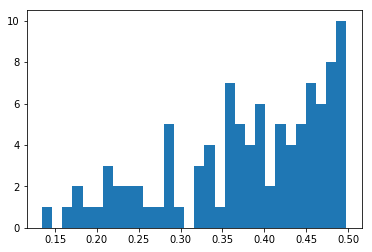

In [13]:
#_ = plt.hist(cat['mag_10'], bins=30)
_ = plt.hist(cat['z_lambda'], bins=30)

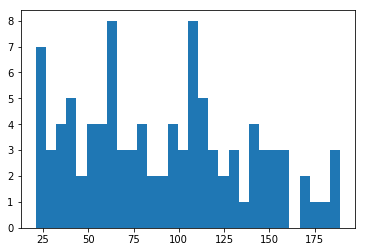

In [14]:
_ = plt.hist(cat['lambda'], bins=30)

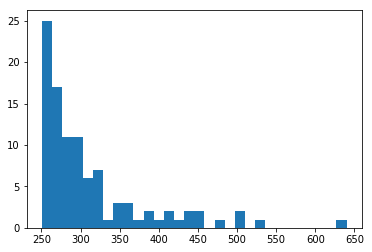

In [15]:
_ = plt.hist(cat['diam'], bins=30)

### Restrict to objects that are in the DR8 footprint.

In [16]:
def read_all_ccds(dr='dr8'):                                                                                                        
    """Read the CCDs files, treating DECaLS and BASS+MzLS separately.                                                               
                                                                                                                                    
    """                                                                                                                             
    from astrometry.libkd.spherematch import tree_open                                                                              
    #survey = LegacySurveyData()                                                                                                    
                                                                                                                                    
    kdccds_north = []                                                                                                               
    for camera in ('90prime', 'mosaic'):                                                                                            
        ccdsfile = os.path.join(drdir, 'survey-ccds-{}-{}.kd.fits'.format(camera, dr))                                              
        ccds = tree_open(ccdsfile, 'ccds')                                                                                          
        print('Read {} CCDs from {}'.format(ccds.n, ccdsfile))                                                                      
        kdccds_north.append((ccdsfile, ccds))                                                                                       
                                                                                                                                    
    ccdsfile = os.path.join(drdir, 'survey-ccds-decam-{}.kd.fits'.format(dr))                                                       
    ccds = tree_open(ccdsfile, 'ccds')                                                                                              
    print('Read {} CCDs from {}'.format(ccds.n, ccdsfile))                                                                          
    kdccds_south = (ccdsfile, ccds)                                                                                                 
                                                                                                                                    
    return kdccds_north, kdccds_south                                                                                               

In [17]:
kdccds_north, kdccds_south = read_all_ccds()

Read 132066 CCDs from /global/project/projectdirs/cosmo/work/legacysurvey/dr8/survey-ccds-90prime-dr8.kd.fits
Read 206834 CCDs from /global/project/projectdirs/cosmo/work/legacysurvey/dr8/survey-ccds-mosaic-dr8.kd.fits
Read 3913907 CCDs from /global/project/projectdirs/cosmo/work/legacysurvey/dr8/survey-ccds-decam-dr8.kd.fits


In [18]:
survey = LegacySurveyData()
survey.output_dir = gallerydir

In [19]:
def get_name(cat, nice=False):
    name = np.atleast_1d(cat['name'])
    if nice:
        outname = name
    else:
        outname = np.array([nn.replace(' ', '-').lower() for nn in name])
    if len(outname) == 1:
        outname = outname[0]
    return outname

In [20]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [21]:
def build_sample_one(cat, verbose=False):
    """Determine the "run", i.e., determine whether we should use the BASS+MzLS CCDs
    or the DECaLS CCDs file when running the pipeline. 

    """
    from astrometry.util.fits import fits_table, merge_tables   
    from astrometry.util.util import Tan                                    
    from astrometry.libkd.spherematch import tree_search_radec  
    from legacypipe.survey import ccds_touching_wcs                         

    ra, dec, diam = cat['ra'], cat['dec'], cat['diam']
    if dec < 25:                        
        run = 'decam'                       
    elif dec > 40:                                      
        run = '90prime-mosaic'      
    else:                               
        width = np.ceil(diam * 60 / PIXSCALE).astype(int)
        wcs = Tan(ra, dec, width/2+0.5, width/2+0.5,
                  -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                  float(width), float(width))  
                        
        # BASS+MzLS 
        TT = []         
        for fn, kd in kdccds_north:
            I = tree_search_radec(kd, ra, dec, 1.0)
            if len(I) == 0:
                continue
            TT.append(fits_table(fn, rows=I))  
        if len(TT) == 0:                    
            inorth = []                     
        else:                           
            ccds = merge_tables(TT, columns='fillzero')     
            inorth = ccds_touching_wcs(wcs, ccds)   
                                    
        # DECaLS            
        fn, kd = kdccds_south  
        I = tree_search_radec(kd, ra, dec, 1.0) 
        if len(I) > 0:          
            ccds = fits_table(fn, rows=I)  
            isouth = ccds_touching_wcs(wcs, ccds)  
        else: 
            isouth = []
        if len(inorth) > len(isouth): 
            run = '90prime-mosaic' 
        else:
            run = 'decam' 
            
        if verbose:
            print('Cluster {}: RA, Dec={:.6f}, {:.6f}: run={} ({} north CCDs, {} south CCDs).'.format(
                cat['name'], ra, dec, run, len(inorth), len(isouth)))
            
        if (len(inorth) == 0) * (len(isouth) == 0):
            run = None
            
    if run:
        cat['run'] = run
        return cat
    else:
        return None

In [22]:
def build_sample(cat, use_nproc=nproc, verbose=False):
    """Build the full sample with grz coverage in DR7."""

    sampleargs = list()
    for cc in cat:
        sampleargs.append( (cc, verbose) )

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))

    #result = list(zip(*result))
    # Remove non-matching objects and write out the sample
    outcat = vstack(list(filter(None, result)))
    print('Found {}/{} clusters in the DR8 footprint.'.format(len(outcat), len(cat)))
    
    return outcat

In [23]:
#rr = build_sample(cat, use_nproc=4, verbose=True)

In [24]:
samplelogfile = os.path.join(gallerydir, 'build-sample.log')
print('Building the sample.')
print('Logging to {}'.format(samplelogfile))
t0 = time.time()
with open(samplelogfile, 'w') as log:
    with redirect_stdout(log):
        sample = build_sample(cat)
print('Found {}/{} objects in the DR8 footprint.'.format(len(sample), len(cat)))
print('Total time = {:.3f} seconds.'.format(time.time() - t0))

Building the sample.
Logging to /global/cscratch1/sd/ioannis/dr8/gallery/build-sample.log
Found 100/100 objects in the DR8 footprint.
Total time = 1.771 seconds.


In [25]:
print('Writing {}'.format(samplefile))
sample.write(samplefile, overwrite=True)

Writing /global/cscratch1/sd/ioannis/dr8/gallery/sample-dr8.fits


In [26]:
#sample

In [27]:
[print(ss['name'].replace(' ', '-'), ss['ra'], ss['dec']) for ss in sample[:10]]
#[print(ss['ra'], ss['dec']) for ss in sample]

RMJ133520.1+410004.1 203.83372267931975 41.0011464409052
RMJ094951.8+170710.6 147.4658410759847 17.119597497572737
RMJ111514.8+531954.6 168.8118656245974 53.33182359555929
RMJ222842.7+083924.4 337.17778435319144 8.656782036448227
RMJ090912.2+105824.9 137.30074463519105 10.97359493545774
RMJ015949.3-084958.9 29.95555555246912 -8.833034764060354
RMJ110608.5+333339.7 166.5353534172606 33.56102371348592
RMJ221145.9-034944.5 332.94131100281584 -3.8290286994715883
RMJ012542.3-063442.3 21.426365942207184 -6.57842375184543
RMJ121218.5+273255.1 183.0770101051668 27.548647731379972


[None, None, None, None, None, None, None, None, None, None]

In [28]:
def qa_sample():
    fig, ax = plt.subplots()
    ax.scatter(cat['ra'], cat['dec'], alpha=0.5, s=10, label='Abell Catalog')
    ax.scatter(sample['ra'], sample['dec'], s=20, marker='s', label='Objects in DR8 Footprint')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='upper right')

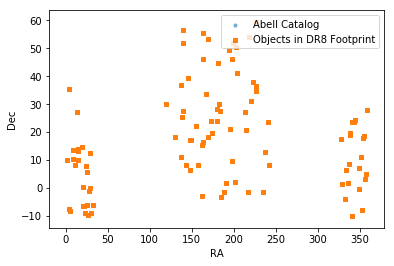

In [29]:
qa_sample()

### Generate the color mosaics for each object.

In [30]:
def custom_brickname(obj, prefix='custom-'): 
    brickname = 'custom-{:06d}{}{:05d}'.format(
        int(1000*obj['ra']), 'm' if obj['dec'] < 0 else 'p', 
        int(1000*np.abs(obj['dec'])))
    return brickname

In [31]:
#name = get_name(sample)
#[print(ii, nn, d1, dd) for ii, (nn, d1, dd) in enumerate(zip(name, sample['diam'], sample['diam'] * 60 / 0.3))]
#print(sample['diam'].data * 60 / 1)

In [32]:
def custom_coadds_one(obj, scale=PIXSCALE, clobber=False, log=None):
    import subprocess
    #from legacypipe.runbrick import run_brick
    #from astrometry.util.multiproc import multiproc
    #from legacypipe.runbrick import stage_tims, run_brick
    #from legacypipe.coadds import make_coadds

    name = get_name(obj)
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        size = obj['diam']
        #size = np.rint(obj['diam'] * 60 / scale).astype('int') # [pixels]
        #if size > 500:
        #    size = 500
        #print('Generating mosaic for {} with width={} pixels.'.format(name, size))
        
        bands = ('g', 'r', 'z')
        rgb_kwargs = dict({'Q': 20, 'm': 0.03})
            
        brickname = custom_brickname(obj, prefix='custom-')
        
        cmd = 'python {legacypipe_dir}/py/legacypipe/runbrick.py '
        cmd += '--radec {ra} {dec} --width {width} --height {width} --pixscale {pixscale} '
        cmd += '--run {run} '
        cmd += '--threads {threads} --outdir {outdir} --no-write '
        #cmd += '--apodize '
        cmd += '--stage image_coadds --skip-calibs '
    
        cmd = cmd.format(legacypipe_dir=os.getenv('LEGACYPIPE_DIR'), 
                         ra=obj['ra'], dec=obj['dec'], run=obj['run'].strip(),
                         width=size, pixscale=scale, threads=nproc, 
                         outdir=gallerydir)
    
        print(cmd, flush=True, file=log)
        err = subprocess.call(cmd.split(), stdout=log, stderr=log)
        if err != 0:
            print('Something we wrong; please check the logfile for {}.'.format(name))
            return 0
        else:
            #with warnings.catch_warnings():
            #    warnings.simplefilter("ignore")
            #    run_brick(None, survey, radec=(obj['ra'], obj['dec']), pixscale=scale, 
            #              width=size, height=size, rgb_kwargs=rgb_kwargs, threads=nproc, 
            #              stages=['image_coadds'], splinesky=True, early_coadds=True, pixPsf=True, 
            #              hybridPsf=True, normalizePsf=True, write_pickles=False, depth_cut=False, 
            #              apodize=True, do_calibs=False, ceres=False)
            #sys.stdout.flush()    
            
            _jpgfile = os.path.join(survey.output_dir, 'coadd', 'cus', brickname, 
                                   'legacysurvey-{}-image.jpg'.format(brickname))
            if os.path.isfile(_jpgfile):
                shutil.copy(_jpgfile, jpgfile)
                shutil.rmtree(os.path.join(survey.output_dir, 'coadd'))
                shutil.rmtree(os.path.join(survey.output_dir, 'metrics'))
            else:
                print('File {} not found; check log!'.format(_jpgfile))

In [33]:
#custom_coadds_one(sample[320], scale=2, clobber=True)

In [34]:
def custom_coadds(sample, clobber=False, log=None):
    for obj in sample:
        custom_coadds_one(obj, clobber=clobber, log=log)

In [35]:
coaddslogfile = os.path.join(gallerydir, 'make-coadds.log')
print('Generating the coadds.')
print('Logging to {}'.format(coaddslogfile))
t0 = time.time()
with open(coaddslogfile, 'w') as log:
    #with redirect_stdout(log):
    custom_coadds(sample, clobber=True, log=log)
print('Total time = {:.3f} minutes.'.format((time.time() - t0) / 60))

Generating the coadds.
Logging to /global/cscratch1/sd/ioannis/dr8/gallery/make-coadds.log
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-226728p34551/legacysurvey-custom-226728p34551-image.jpg not found; check log!
File /global/cscratch1/sd/ioannis/dr8/gallery/coadd/cus/custom-003236p35530/legacysurvey-custom-003236p35530-image.jpg not found; check log!
Total time = 51.255 minutes.


### Add labels and a scale bar.

In [57]:
barlen = np.round(15.0 / PIXSCALE).astype('int')
fonttype = os.path.join(gallerydir, 'Georgia-Italic.ttf')

In [74]:
def _add_labels_one(args):
    """Wrapper function for the multiprocessing."""
    return add_labels_one(*args)

In [75]:
def add_labels_one(obj, verbose=False):
    name = get_name(obj)
    nicename = get_name(obj, nice=True)
    
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    pngfile = os.path.join(pngdir, '{}.png'.format(name))
    thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(name))
    
    if os.path.isfile(jpgfile):
        im = Image.open(jpgfile)
        sz = im.size
        fntsize = np.round(sz[0]/28).astype('int')
        if fntsize < 10:
            fntsize = 10
        width = np.round(sz[0]/175).astype('int')
        font = ImageFont.truetype(fonttype, size=fntsize)
        draw = ImageDraw.Draw(im)
        # Label the object name--
        draw.text((0+fntsize*2, 0+fntsize*2), nicename, font=font)
        # Add a scale bar--
        x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
        draw.line((x0, yy, x1, yy), fill='white', width=width)
        im.save(pngfile)    
        
        # Generate a thumbnail
        if False:
            cmd = '/usr/bin/convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
            os.system(cmd)
    else:
        print('File {} not found.'.format(jpgfile))

In [76]:
def add_labels(sample):
    labelargs = list()
    for obj in sample:
        labelargs.append((obj, False))

    #if False:
    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        res = p.map(_add_labels_one, labelargs)
        p.close()
    else:
        for args in labelargs:
            res = _add_labels_one(args)

In [77]:
%time add_labels(sample)

File /global/cscratch1/sd/ioannis/dr8/gallery/jpg/rmj150654.9+343306.1.jpg not found.
File /global/cscratch1/sd/ioannis/dr8/gallery/jpg/rmj001256.8+353148.1.jpg not found.
CPU times: user 205 ms, sys: 307 ms, total: 513 ms
Wall time: 40.3 s


### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do

```bash
rsync -auvPn --delete /global/cscratch1/sd/ioannis/dr8/gallery/png /global/project/projectdirs/cosmo/www/temp/ioannis/dr8/gallery/
rsync -auvPn /global/cscratch1/sd/ioannis/dr8/gallery/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/dr8/gallery/
```
    
and then navigate to

https://portal.nersc.gov/project/cosmo/temp/ioannis/dr8/gallery/

In [78]:
reject = ['rmj150654.9+343306.1', 'rmj001256.8+353148.1']
toss = np.zeros(len(sample), dtype=bool)
name = get_name(sample)
for ii, nn in enumerate(name):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in nn.lower()
        if toss[ii]:
            break
print('Rejecting {} objects.'.format(np.sum(toss)))
pngkeep = sample[~toss]
if np.sum(toss) > 0:
    pngrej = sample[toss]
else:
    pngrej = []

Rejecting 2 objects.


In [79]:
htmlfile = os.path.join(gallerydir, 'index.html')
htmlfile_reject = os.path.join(gallerydir, 'index-reject.html')
baseurl = 'http://legacysurvey.org/viewer'

In [83]:
def html_rows(pngkeep, nperrow=4):
    nrow = np.ceil(len(pngkeep) / nperrow).astype('int')
    pngsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(pngkeep):
            i2 = len(pngkeep)
        pngsplit.append(pngkeep[i1:i2])
    #pngsplit = np.array_split(pngkeep, nrow)
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table class="ls-gallery">\n')
    html.write('<tbody>\n')
    for pngrow in pngsplit:
        html.write('<tr>\n')
        for obj in pngrow:
            name = get_name(obj)
            nicename = get_name(obj, nice=True)
            pngfile = os.path.join('png', '{}.png'.format(name))
            thumbfile = os.path.join('png', '{}.png'.format(name))
            #thumbfile = os.path.join('png', 'thumb-{}.png'.format(name))
            img = 'src="{}" alt="{}"'.format(thumbfile, nicename)
            #img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, nicename)
            html.write('<td><a href="{}"><img {} width=300px></a></td>\n'.format(pngfile, img))
        html.write('</tr>\n')
        html.write('<tr>\n')
        for obj in pngrow:
            nicename = get_name(obj, nice=True)
            href = '{}/?layer={}&ra={:.8f}&dec={:.8f}&zoom=12'.format(baseurl, dr, obj['ra'], obj['dec'])
            html.write('<td><a href="{}" target="_blank">{}</a></td>\n'.format(href, nicename))
        html.write('</tr>\n')
    html.write('</tbody>\n')            
    html.write('</table>\n')

In [84]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('table.ls-gallery {width: 90%;}\n')
    #html.write('img.ls-gallery {display: block;}\n')
    #html.write('td.ls-gallery {width: 100%; height: auto}\n')
    #html.write('td.ls-gallery {width: 100%; word-wrap: break-word;}\n')
    html.write('p.ls-gallery {width: 80%;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>DR8 Image Gallery</h1>\n')
    
    html.write("""<p class="ls-gallery">This data release's gallery highlights galaxy clusters, 
    distant systems containing tens to thousands of individual galaxies and usually containing
    a single, large, dominant galaxy at the very center.  The sample presented here is taken
    from the <a href="http://risa.stanford.edu/redmapper/">redMaPPer/v6.3</a> cluster catalog.</p>\n
    
    <p class="ls-gallery">The diameter of each image cutout equals 400 kiloparsecs (more than 1.2 million light-years) at the 
    redshift of the cluster.  The clusters are sorted by increasing richness or dark matter halo mass,
    ranging between approximately 3x10<sup>15</sup> solar masses (top, left-hand side of the page)
    to 1x10<sup>14</sup> solar masses (bottom-right).</p>\n
    
    <p class="ls-gallery">The object name below each thumbnail links to the <a href="http://legacysurvey.org/viewer">Sky Viewer</a>, 
    and the horizontal white bar in the lower-right corner of each image represents 15 arcseconds.</p>\n""")
    
    #<p class="ls-gallery">For more eye candy, please visit the gallery of objects highlighted in the 
    #<a href="http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr7/gallery/">DR7 Gallery.</a></p>\n""")
    
    html_rows(pngkeep)
    html.write('<br />\n')

    html.write('</body></html>\n')

Splitting the sample into 25 rows with 4 mosaics per row.


In [82]:
if len(pngrej) > 0 and False:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><head>\n')
        html.write('<style type="text/css">\n')
        html.write('img.ls-gallery {display: block;}\n')
        html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
        html.write('</style>\n')
        html.write('</head><body>\n')
        html.write('<h1>DR8 Image Gallery - Rejected</h1>\n')
        html_rows(pngrej)
        html.write('</body></html>\n')